# Curaio - TechLabs Project Summer Term 2019

__Hint:__ use show/hide code next cell toggle to hide the code cells for increased readability while going through the notebook.

In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'show/hide code'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [18]:
hide_toggle(for_next=True)

In [3]:
# importing packages and libraries needed for this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import time
from datetime import datetime
from pytrends.request import TrendReq
import pytrends
from random import randint
import pmdarima as pm
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import datetime
import xgboost as xgb
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')

In [2]:
hide_toggle(for_next=True)

In [5]:
# defining functions used in this notebook

def get_usdata(kw_list):
    """takes keyword list as input and returns DataFrame
    containing ili rates for the state and Google Trends 
    data for the keywords"""
    
    # ili data
    us_ili = pd.read_csv("ili_national_level.csv", header=0)
    us_ili["date"] = pd.to_datetime(us_ili.week.astype(str) + us_ili.year.astype(str).add("-0"), format="%W%Y-%w")
    us_ili.set_index("date", inplace=True)
    ili = us_ili.shift(-1, freq='W')
       
    
    # Google Trends
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(kw_list, cat=0, timeframe="2015-01-11 2019-07-07", geo="US")
    trends = pytrends.interest_over_time()
    trends = trends.drop("isPartial", axis=1)
    
    # merge the dataframes on the Datetimeindex
    merged = trends.join(ili)
    merged["unweighted_ili"] = merged["unweighted_ili"].interpolate(method="linear")
    merged = merged.drop(merged.tail(4).index, inplace=False)
    merged = merged.asfreq("W")
    merged = merged.drop(['Unnamed: 0', 'region_type', 'region', 'year', 'week', 'weighted_ili','age_0_4', 'age_25_49', 'age_25_64', 'age_5_24', 'age_50_64', 'age_65', 'ilitotal', 'num_of_providers', 'total_patients', 'week_start'], axis=1)
    
    return merged
 
    
def rmse(testdf, preddf):
    """takes two dataframes as input: testdf containing (true) test data 
    and preddf containing predictions made with a forecasting model;
    returns the root mean squared error as evaluation metric"""
    
    return np.sqrt(mean_squared_error(testdf, preddf))

## 1. Introduction and aim of the project

The aim of the project is to predict disease rates, more precisely influenza-like illnesses rates (ILI rates). On the one hand historical time series data were used, on the other hand the data basis was extended by Google Trends data. According to [Google News Lab](https://medium.com/google-news-lab/what-is-google-trends-data-and-what-does-it-mean-b48f07342ee8) these data are  
> "normalized Trends data. This means that when we look at search interest over time for a topic, we’re looking at that interest as a proportion of all searches on all topics on Google at that time and location".

The data is indexed to 100, where 100 is the maximum search interest for the time and location selected. The idea was that people may google typical flu symptoms at the onset of a cold or flu even before the disease fully manifests itself. The explanatory variables for the ILI rates were therefore defined as a combination of keywords containing such typical symptoms of influenza. 

## 2. Data acquisition and engineering

Initially, it was planned to carry out the project on the basis of data for Germany. However, due to the lack of freely accessible influenza data, we decided to do the project for the USA. The ILI rates could be obtained using the R Package [cdcfluview](https://rdrr.io/cran/cdcfluview/) and its ilinet function. This function retrieves data from the CDC FluView Portal containing, inter alia, in-season and past seasons' national, regional, and state-level outpatient illness surveillance data from ILINet (Influenza-like Illness Surveillance Network). <br><br>
The Google Trends data were obtained using Python's [pytrends](https://github.com/GeneralMills/pytrends), an unofficial pseudo API for extracting Google Trends data. As a combination of keywords, the following typical symptoms were identified:
- fever
- flu
- cough
- sore throat
- headache

For this project data was used ranging from the beginning of 2015 until July 2019, so over approximately four and a half years. Since ILI rates are reported on a weekly basis, also Google Trends data on a weekly basis were used. Therefore the data amounts to around 230 data points.

## 3. Exploratory data analysis

### 3.1 ILI Rates

Before starting the modeling process and forecasting, there was a brief exploratory data analysis of our target variable, the ILI rates, as a first step. Therefore, the first step was to load the data into a Pandas dataframe and to construct a datetime index using the week number and year variables, on which later on the ili rates dataframe and the dataframe containing the google Trends data were merged. <br>
Then the ILI rate time series were plotted to get a first intuition and feeling for the data.

In [3]:
hide_toggle(for_next=True)

In [7]:
#load national level ili rates into a dataframe and setting week and year as datetime index
us_ili = pd.read_csv("ili_national_level.csv", header=0)
us_ili["date"] = pd.to_datetime(us_ili.week.astype(str) + us_ili.year.astype(str).add("-0"), format="%W%Y-%w")
us_ili.set_index("date", inplace=True)
ili_df = us_ili.shift(-1, freq='W')
ili_df = ili_df[ili_df.year!=2014]
ili = ili_df["unweighted_ili"]

In [4]:
hide_toggle(for_next=True)

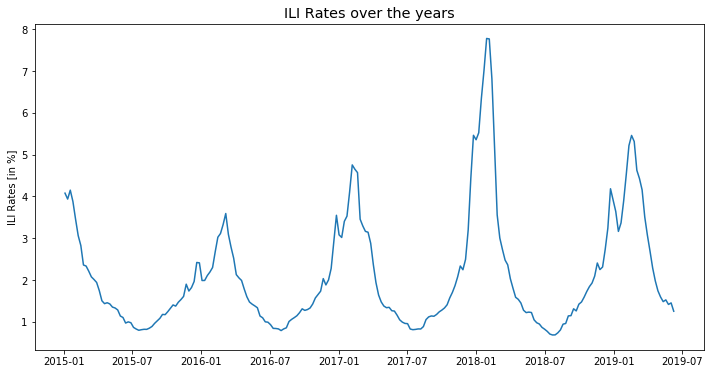

In [9]:
plt.figure(figsize=(12,6))
plt.plot(ili)
plt.title("ILI Rates over the years", fontsize="x-large", weight="roman");
plt.ylabel("ILI Rates [in %]");

From the above plot one can see that the rates are the lowest in the middle of each year in the summer months. From the late summer months on they start to rise. During the autumn this rise is pretty modest, however, as winter comes closer the increase in ILI rates becomes much more drastically at the end of a year and in the beginning of the following year. The rates typically peak in late January or February each year, before they start to decrease again until the middle of the year. <br>
Although the level of ILI rates changes during the observed period, the plot displays qualitatively a very similar picture for each year with the typical characteristics described before. Therefore, there is strong (yearly) seasonality in our data which has to be considered when modeling and forecasting. This seasonality can also be seen quite well when plotting the ILI rates against the calendar weeks (see plot below): the rates are almost identical in the middle of the year from around the 15th to the 50th week in all years. Only in the weeks during which the influenza rates peak there are differences in the level of the rates, but the typical course is constant over all years.

In [5]:
hide_toggle(for_next=True)

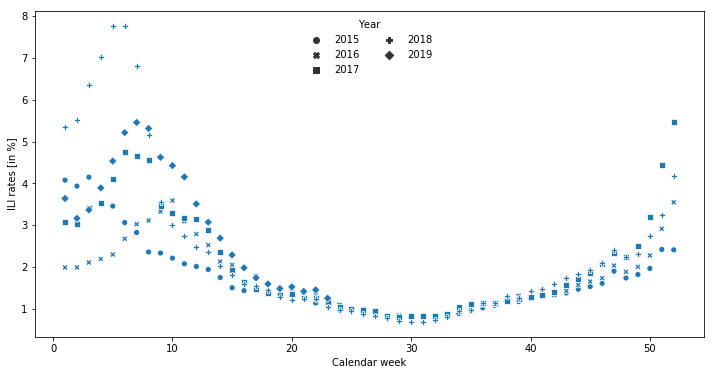

In [11]:
#ili_df["year"] = ili_df["year"].astype("category")
fig, ax = plt.subplots(figsize=(12,6))
scat = sns.scatterplot(data=ili_df, x="week", y="unweighted_ili", style="year");
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], ncol=2, loc="upper center", frameon=False)
scat.legend_.set_title("Year")
plt.xlabel("Calendar week");
plt.ylabel("ILI rates [in %]");


### 3.2 Google Trends

In the next step the Google Trends data was analyzed. As explained in the introduction of this notebook, the keywords used for this project are a combination of typical symptoms of a flu or influenza. The identified keywords used in this project are:
- fever
- flu
- cough
- sore throat
- headache

The data was aquired using the Python package Pytrends. Firstly, the data was loaded into a pandas dataframe and then plotted just as before with the ILI rates data.

In [6]:
hide_toggle(for_next=True)

In [13]:
# loading the data into a dataframe
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
pytrends = TrendReq(hl='en-US', tz=360)
pytrends.build_payload(kw_list, cat=0, timeframe="2015-01-11 2019-07-07", geo="US")
trends = pytrends.interest_over_time()
trends = trends.drop("isPartial", axis=1)
trends["week"] = trends.index.weekofyear
trends["year"] = trends.index.year

In [7]:
hide_toggle(for_next=True)

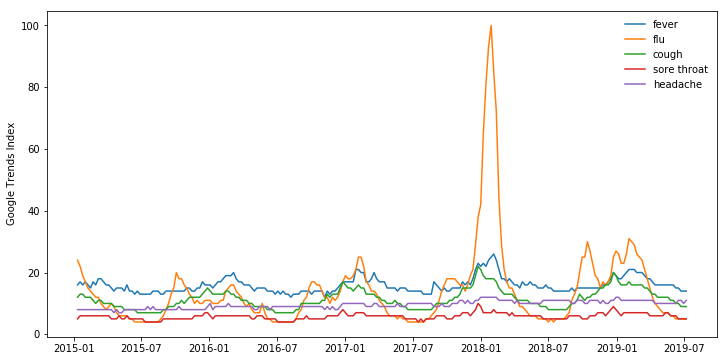

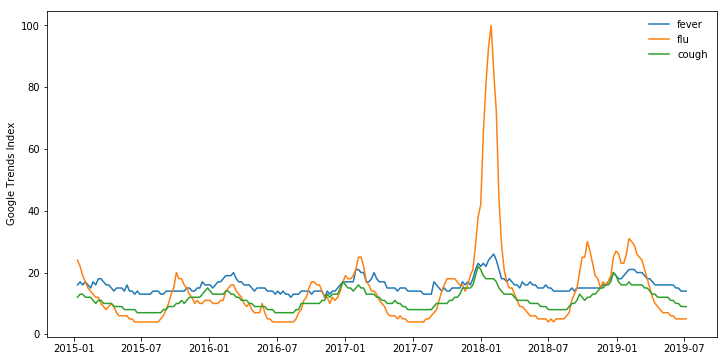

In [15]:
# creating the plot
plt.figure(figsize=(12,6))
plt.plot(trends.fever);
plt.plot(trends.flu);
plt.plot(trends.cough);
plt.plot(trends["sore throat"]);
plt.plot(trends.headache);
plt.legend(frameon=False);
plt.ylabel("Google Trends Index");

# creating second plot
plt.figure(figsize=(12,6))
plt.plot(trends.fever);
plt.plot(trends.flu);
plt.plot(trends.cough);
plt.legend(frameon=False);
plt.ylabel("Google Trends Index");

Although a bit messy due to the many curves, the first of the plots shown above pictures qualitatively a very similar picture to the plot showing the course of ILI rates over the years. The search volume for the chosen keywords is the lowest during summer months and the middle of each year. From then on it rises until it reaches its peak around February. This is most evident for the keywords fever, flu and cough as can be seen in the second plot above.

Using the same way of displaying the relationship between calendar weeks and the respective Google Trends index as for the relationship between ILI rates and calendar weeks before, a very similar picture emerges, though not as clear as before: the search volume for typical flu and influenza symptoms is lowest during the summer months, increases slowly during autumn, more rapidly during winter months and peaks around February.

In [8]:
hide_toggle(for_next=True)

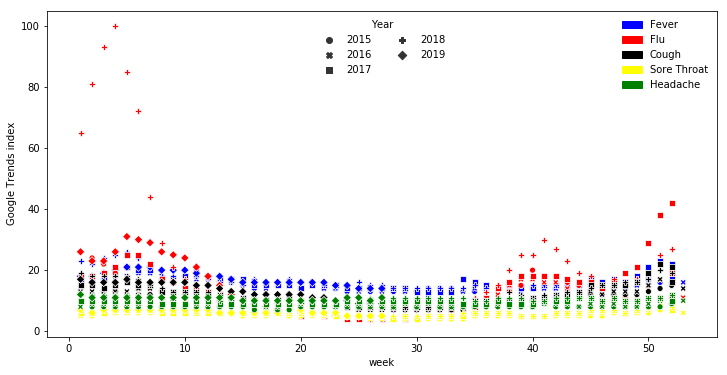

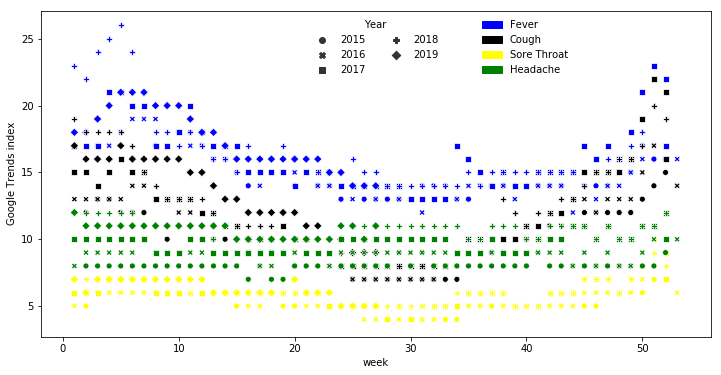

In [17]:
### first plot ###
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=trends, x="week", y="fever", style="year", color="blue");
sns.scatterplot(data=trends, x="week", y="flu", style="year", color="red", legend=False);
sns.scatterplot(data=trends, x="week", y="cough", style="year", color="black", legend=False);
sns.scatterplot(data=trends, x="week", y="sore throat", style="year", color="yellow", legend=False);
sns.scatterplot(data=trends, x="week", y="headache", style="year", color="green", legend=False);
# second legend for colors
blue_patch = mpatches.Patch(color="blue", label="Fever");
red_patch = mpatches.Patch(color='red', label='Flu');
black_patch = mpatches.Patch(color='black', label='Cough');
yellow_patch = mpatches.Patch(color="yellow", label="Sore Throat");
green_patch = mpatches.Patch(color="green", label="Headache");
leg2 = plt.legend(handles=[blue_patch, red_patch, black_patch, yellow_patch, green_patch], loc="upper right", frameon=False);
plt.ylabel("Google Trends index")
# legend for years
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles=handles[1:], labels=labels[1:], ncol=2, loc="upper center", frameon=False);
ax.legend_.set_title("Year");
ax.add_artist(leg2);

### second plot
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(data=trends, x="week", y="fever", style="year", color="blue");
sns.scatterplot(data=trends, x="week", y="cough", style="year", color="black", legend=False);
sns.scatterplot(data=trends, x="week", y="sore throat", style="year", color="yellow", legend=False);
sns.scatterplot(data=trends, x="week", y="headache", style="year", color="green", legend=False);
# second legend for colors
blue_patch = mpatches.Patch(color="blue", label="Fever");
black_patch = mpatches.Patch(color='black', label='Cough');
yellow_patch = mpatches.Patch(color="yellow", label="Sore Throat");
green_patch = mpatches.Patch(color="green", label="Headache");
leg2 = plt.legend(handles=[blue_patch, black_patch, yellow_patch, green_patch], loc='upper right', bbox_to_anchor=(0.8, 1) , frameon=False);
plt.ylabel("Google Trends index")
# legend for years
handles, labels = ax.get_legend_handles_labels();
ax.legend(handles=handles[1:], labels=labels[1:], ncol=2, loc="upper center", frameon=False);
ax.legend_.set_title("Year");
ax.add_artist(leg2);

### 3.3 Both: ILI Rates and Google Trends

Plotting both ILI rates and Google Trends data together in a single graph shows that the two curves seem to run pretty much together and follow the same course.

In [9]:
hide_toggle(for_next=True)

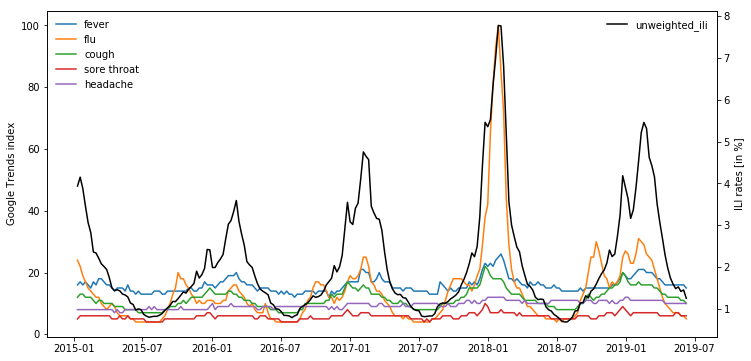

In [19]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
us_ili = get_usdata(kw_list)
fig, ax1 = plt.subplots(figsize=(12,6))
# first y axis [Google Trends]
ax1.set_ylabel("Google Trends index");
trends = us_ili.drop(["unweighted_ili"], axis=1);
ax1.plot(trends.fever);
ax1.plot(trends.flu);
ax1.plot(trends.cough);
ax1.plot(trends["sore throat"]);
ax1.plot(trends.headache);
ax1.legend(frameon=False, loc="upper left");
# second y axis [ILI Rates]
ax2 = ax1.twinx();
ax2.set_ylabel("ILI rates [in %]")
ax2.plot(us_ili["unweighted_ili"], color="black")
ax2.tick_params(axis="y");
ax2.legend(frameon=False, loc="upper right");

This first graphical intuition of the time series more or less running together can also be tested more rigorously using the correlation coefficient between the search volume of each keyword and the ILI rates. Displaying the correlation matrix between all variables confirms our first intuition. There is a high correlation between the Google Trends data and the ILI rates for most of the keywords. Especially for the keywords fever, flu and cough there is a very high correlation coefficient of around 0.912, 0.840 and 0.848, respectively, showing that these time series are highly correlated. The correlation coefficient for sore throat is still pretty high (0.730), for headache substantially lower (0.458). There is also high correlation between some of the keywords, e.g. between cough and sore throat (0.875). However, we are still going to keep all of the keywords as explanatory variables. 

In [20]:
us_ili.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.763863,0.817337,0.760097,0.526859,0.919887
flu,0.763863,1.000000,0.698055,0.529569,0.499043,0.841872
cough,0.817337,0.698055,1.000000,0.869852,0.527671,0.855295
sore throat,0.760097,0.529569,0.869852,1.000000,0.504152,0.729051
headache,0.526859,0.499043,0.527671,0.504152,1.000000,0.448145
unweighted_ili,0.919887,0.841872,0.855295,0.729051,0.448145,1.000000


Since our goal is to predict future ILI rates using the Google Trends data, a high correlation between Google Trends and ILI rates from the same period is not what we are really interested in. The more interesting question for this application is if there is a substantially high relationship between Google Trends data and future ILI rates. To test this, the Google Trends data are shifted one period into the future, such that these data correspond to the one-week-ahead ILI rates in the DataFrame. <br>
Looking at the correlation coefficients of the lagged Google Trends data and the ILI Rates it can be seen that the correlation is almost as high as for the non-lagged data. The correlation coefficient between ILI Rates (and lagged) Fever is a bit lower (0.885 vs. 0.913), the ones between ILI Rates and (lagged) Flu (0.840 vs. 0.840), (lagged) sore throat (0.732 vs. 0.731) and (lagged) headache (0.461 vs. 0.458) remain mostly unchanged and the correlation between ILI Rates and lagged search volume for cough even increased slightly (0.867 vs. 0.848). This high correlation between ILI rates and the lagged Google Trends data suggests that it may be well possible to predict ILI rates using the given index data. 

In [21]:
us_ili_shift = us_ili[["fever", "flu", "cough", "sore throat", "headache"]].shift(1, freq="W")
us_ili_shift["unweighted_ili"] = us_ili["unweighted_ili"]
us_ili_shift.corr()

,fever,flu,cough,sore throat,headache,unweighted_ili
fever,1.000000,0.763863,0.817337,0.760097,0.526859,0.894615
flu,0.763863,1.000000,0.698055,0.529569,0.499043,0.840828
cough,0.817337,0.698055,1.000000,0.869852,0.527671,0.873549
sore throat,0.760097,0.529569,0.869852,1.000000,0.504152,0.719603
headache,0.526859,0.499043,0.527671,0.504152,1.000000,0.448614
unweighted_ili,0.894615,0.840828,0.873549,0.719603,0.448614,1.000000


## 4. Forecasting and model evaluation

After cleaning the data, getting it into the right format, i.e. a single dataframe containing both ILI rates and Google Trends index data merged on a datetime index, the models to forecast the data were created and compared on their prediction accuracy. For comparison and evaluation the Root Mean Squared Error (RMSE) metric was used. This metric takes the difference between the forecasted datapoint and the actual value (i.e. the residual) and squares it, does this for each single datapoint, averages the squared residuals and takes the square root of this average. Thus, the RMSE can be written as:<br>
> $ RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y_i})^2}   $ 

In comparison to other common evaluation metrics which can be used for regression or forecasting tasks, as for example the Absolute Mean Error (MAE), the RMSE gives relatively high weight to large errors since the errors are squared before they are averaged and thus these  are penalized more. However, in contrast to the MAE, the RMSE cannot be interpreted as nicely. <br>
<br>
Before using the Google Trends data to forecast ILI rates two classical univariate forecasting methods were used: a model of the ARMA model class and Holt-Winter's Triple Exponential Smoothing method.

### 4.1 Univariate Forecasting

#### 4.1.1 auto.arima 

The first class of models fit to the data and used to make predictions is the class of Auto Regressive Moving Average (ARMA) models. Such a model has got many different parameters that have to be chosen before fitting the model to get decent results. To avoid choosing all of those parameters in advance, the Python package pmdarima and its auto_arima() function were used. This function grid searches through a combination of parameters and chooses the model which minimizes some information criteria (the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC)). <br>
The only parameter that has to be known and set before running the function is the order of seasonality $m$. As we saw earlier in Chapter 3.1 of this Notebook, the data exhibits very strong and clear seasonality, which repeats on a yearly cycle. Since the data is on a weekly basis, one seasonal cycles corresponds to 52 weeks, and therefore $m=52$ was chosen before running auto_arima().

In [10]:
hide_toggle(for_next=True)

In [23]:
# getting the data
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_us = get_usdata(kw_list)
ili = ili_us["unweighted_ili"]

# defining train and test / forecasting data
# making forecasts for the last 52 weeks in the dataset, i.e. for a whole year
train = ili.iloc[:179]
test = ili.iloc[179:]

In [24]:
# fitting the model
arima = pm.auto_arima(train, start_p=1, start_q=1, m=52, seasonal=True, trace=1, error_action="ignore", suppress_warnings=True)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 52); AIC=0.038, BIC=19.162, Fit time=37.483 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 52); AIC=622.949, BIC=629.323, Fit time=0.016 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 52); AIC=74.526, BIC=87.276, Fit time=24.101 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=331.090, BIC=343.839, Fit time=19.996 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=-1.966, BIC=13.970, Fit time=21.823 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 52); AIC=35.574, BIC=48.323, Fit time=0.347 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 2, 52); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 1, 52); AIC=-22.859, BIC=-3.734, Fit time=16.861 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 1, 52); AIC=-23.880, B

Running the auto_arima() function, the model chosen corresponds to a seasonal ARMA model without differencing (which can be done to ensure stationarity of a time series), i.e. a SARMA model. In the next step, we initialized an empty list, in which the predictions are stored. We first make a one-period-ahead forecast, save the forecast in the forecasts list, update our model using the actual value of the just forecasted period and then use the updated model to predict the next period. This is done for all timepoints in our test dataset.

In [25]:
# one-period-ahead forecast and updating model parameters after each prediction
model = arima 
arima_pred = []
for new_ob in test:
    fc = model.predict(n_periods=1)[0]
    arima_pred.append(fc)
  
    # updates existing model with a small number of MLE steps
    model.update(new_ob, suppress_warnings=True)

In the graph below the actual and the predicted ILI Rates are plotted against the timepoints. This graph can be used to evaluate the performance of our prediction. At a first glance, the prediction looks very close to the actual values. This first graphical intuition is also confirmed using the RMSE criterion. Our forecast yields a RMSE of 0.251 as can also be seen from the plot.

In [11]:
hide_toggle(for_next=True)

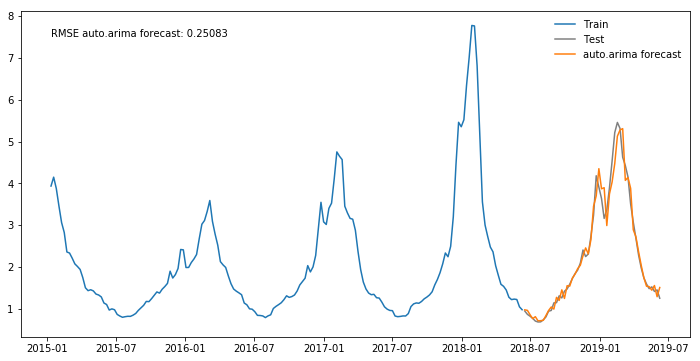

In [28]:
# visualizing the results
# computing RMSE
rmse_arima = round(rmse(test, arima_pred), 6)
# creating figure
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color="grey")
plt.plot(test.index, arima_pred, label="auto.arima forecast")
plt.text(train.index[0], 7.5, "RMSE auto.arima forecast: " + str(rmse_arima))
plt.legend(loc='upper right', frameon=False)
plt.show()

#### 4.1.2 Holt-Winters' seasonal method

After trying the ARMA class models, another univariate model to make the forecasts was used, namely the Triple Exponential Smoothing method, also known as Holt-Winters model. This model can be used for time series data which exhibit seasonalities to make forecasts and is another classical and commonly used model for time series prediction and is thus also used here. In the same manner as before, a one-step-ahead forecast is produced, the model is updated using the actual value for the forecasted period and then the ILI rate for the next period is predicted.

In [12]:
hide_toggle(for_next=True)

In [30]:
# getting the data
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili_us = get_usdata(kw_list)
ili = ili_us["unweighted_ili"]

# defining train and test / forecasting data
# making forecasts for the last 52 weeks in the dataset, i.e. for a whole year
train = ili.iloc[:179]
test = ili.iloc[179:]

In [31]:
holt = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=52)
holt_fit = holt.fit(optimized=True)

i = 0
holt_pred = pd.DataFrame(test)
for new_ob in test:
    fc = holt_fit.predict(start=test.index[i], end=test.index[i])
    holt_pred[i] = fc
    # add test obs to train df
    train[test.index[i]] = test.values[i]
    holt = ExponentialSmoothing(train, trend=None, seasonal="add", seasonal_periods=52)
    holt_fit = holt.fit(optimized=True)
    # increasing i
    i = i+1
    
# keeping only predicted values
aux = holt_pred.drop(["unweighted_ili"], axis=1)
aux = np.diag(aux)
pred_holt = pd.DataFrame(aux, test.index)

The same way of graphical evaluation and quantitative evaluation using the RMSE was used as with the SARMA model. The Holt-Winters prediction seems to be as close to the actual test values as the SARMA model for the first few periods and also for the decline after the rates have peaked. However, the model does not capture the drop on the way to the peak and in addition to that the prediction seems to be too low for the period between the drop and the peak. The RMSE amounts to around 0.420 and therefore confirms that the Holt-Winters model performs worse than the SARMA model used before.

In [13]:
hide_toggle(for_next=True)

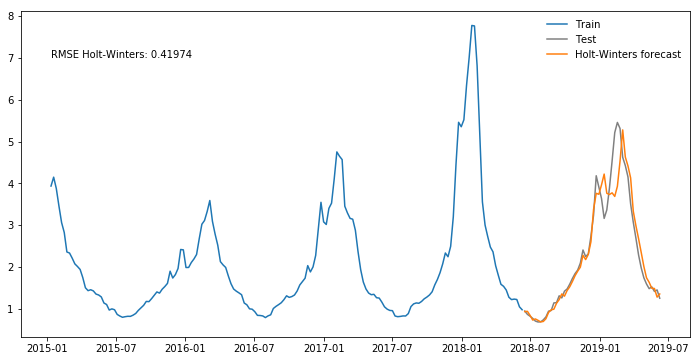

In [33]:
# resetting train and test datasets for plotting
train = ili.iloc[:179]
test = ili.iloc[179:]
# calculating RMSE
rmse_holt = round(rmse(test, pred_holt), 6)
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color="grey")
plt.plot(pred_holt.index, pred_holt, label='Holt-Winters forecast')
plt.text(train.index[0], 7, "RMSE Holt-Winters: " + str(rmse_holt))
plt.legend(loc='best', frameon=False)
plt.show()

### 4.2 Multivariate Forecasting: XGBoost

Since the goal was to forecast ILI rates using Google search volumes for typical influenza and flu symptoms, in addition to the historical time series data of ILI rates themselves the Google Trends index data described in 3.2 were used as well. The algorithm used was the XGBoost regression model. XGBoost is a tree-based machine learning algorithm using boosted trees. It is very efficient, needs relatively low computing time, is able to handle missing values and uses regularization to avoid overfitting (for more details see for example [the XGBoost documentation](https://xgboost.readthedocs.io/en/latest/)). <br>
To get the dataframe into the desired format, at first the Google Trends data were shifted one period into the future, such that this week's Google Trends index data correspond to next week's ILI rates. Before training the XGBoost model, there are some hyperparameters which have to be set in advance. Since XGBoost tends to work very well without much tuning or adjustment, only two hyperparameters were changed: first, it was found that a value of 1 for the learning rate works best for the problem at hand, while typically smaller numbers between 0.01 and 0.3 tend to work well; and second, we increased the maximum depth of a single tree to allow for a higher flexibility. The remaining parameters were kept as set by default.

In [14]:
hide_toggle(for_next=True)

In [35]:
kw_list = ["fever", "flu", "cough", "sore throat", "headache"]
ili =  get_usdata(kw_list)
# get week and month variable as numerical variable
ili["week"] = ili.index.weekofyear
ili["month"] = ili.index.month
ili["year"] = ili.index.year
# shift Google Trends data one period into the future / ILI rates one period back
ili_shift = ili[["fever", "flu", "cough", "sore throat", "headache"]].shift(1, freq="W")
ili_shift["unweighted_ili"] = ili["unweighted_ili"]
ili_shift["year"] = ili["year"]
ili_shift["week"] = ili["week"]
ili_shift["month"] = ili["month"]
# split data into train and test datasets
train = ili_shift.iloc[:178]
test = ili_shift.iloc[178:]
test = test.drop(datetime.datetime(2019,6,16), axis=0)

In [15]:
hide_toggle(for_next=True)

In [48]:
# train XGBoost regression model and make predictions
dtrain = xgb.DMatrix(train, label=train["unweighted_ili"])
dtest = xgb.DMatrix(test, label=test["unweighted_ili"])
param = {'max_depth':10, 'eta':1, 'objective':'reg:squarederror' }
num_round = 5
bst = xgb.train(param, dtrain, num_round)
xgb_pred = bst.predict(dtest)

In [16]:
hide_toggle(for_next=True)

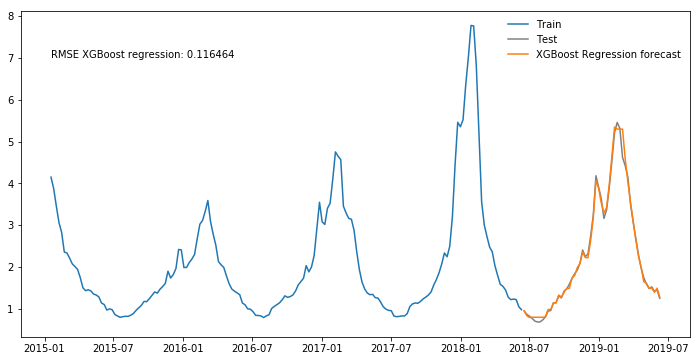

In [49]:
# compute RMSE
test_y = test["unweighted_ili"]
xgb_pred = pd.DataFrame(xgb_pred)
rmse_xgb = round(rmse(test_y, xgb_pred), 6)
# create plot
plt.figure(figsize=(12,6))
plt.plot(train.index, train["unweighted_ili"], label='Train')
plt.plot(test.index, test["unweighted_ili"], label='Test', color="grey")
plt.plot(test.index, xgb_pred, label='XGBoost Regression forecast')
plt.text(train.index[0], 7, "RMSE XGBoost regression: " + str(rmse_xgb))
plt.legend(loc='best', frameon=False)
plt.show()

The plotted prediction looks very close to the actual test values. Even the two drops are captured well, especially compared to the Holt-Winters model used before. The RMSE is also very low with around only 0.116.

## 5. Model comparison and conclusion

Using univariate forecasting methods, the SARMA model outperformed the Holt-Winters model, however, both models yielded a pretty precise estimate of one-period-ahead ILI rates forecasts. A more modern Machine Learning approach, using the XGBoost algorithm with Google Trends index data of typical flu and influenza symptoms as explanatory variables instead of historical ILI rates themselves as input to the model, performed even better than the already very precise SARMA model and thus also better than the Holt-Winters method. The graph below plots the actual and predicted ILI rates against the timepoints for all 3 models and their RMSE for a direct comparison.

In [17]:
hide_toggle(for_next=True)

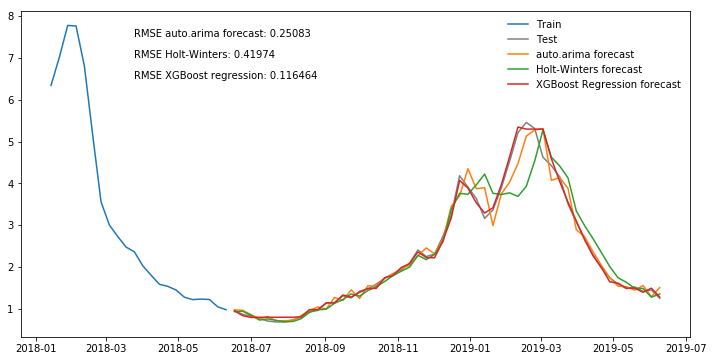

In [50]:
plt.figure(figsize=(12,6))
plt.plot(train.iloc[156:].index, train["unweighted_ili"].iloc[156:], label='Train')
plt.plot(test.index, test["unweighted_ili"], label='Test', color="grey")
plt.plot(test.index, arima_pred, label="auto.arima forecast")
plt.text(train.index[166], 7.5, "RMSE auto.arima forecast: " + str(rmse_arima))
plt.plot(pred_holt.index, pred_holt, label='Holt-Winters forecast')
plt.text(train.index[166], 7, "RMSE Holt-Winters: " + str(rmse_holt))
plt.plot(test.index, xgb_pred, label='XGBoost Regression forecast')
plt.text(train.index[166], 6.5, "RMSE XGBoost regression: " + str(rmse_xgb))
plt.legend(loc='best', frameon=False)
plt.show()

To sum up, both (classical) univariate and multivariate (machine learning) forecasting methods gave very precise and accurate results for a forecasting horizon of one period. However, the XGBoost [RMSE: 0.116] outperforms the SARMA model [RMSE: 0.251] as well as the Holt-Winters' Triple Exponential Smoothing model [RMSE: 0.420]. <br>

One possible extension of this project would be to increase the forecasting horizon. Especially in the field of HR and workforce planning it would be useful to have precise estimates of how ILI rates and therefore sick leaves develop over a longer time period. Therefore, it would be interesting to evaluate and compare these three models when predicting longer time horizons, e.g. two, four or six weeks ahead.